# <span style="font-size: 36px;"> Imports </span>
---

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pywt

from calcula_descritores import calculate_statistics
from calcula_metricas import calculate_metrics
# from calcula_wavelet import plot_wavelet_coeffs

# <span style="font-size: 36px;"> Modelo de classificação baseado em k-NN </span>
---

## <span style="font-size: 28px;"> Extraindo e preparando os Dados </span>

In [2]:
# Caminho relativo para o arquivo 'mat_vibration.mat'
caminho_arquivo = "C:\\Users\\Mathe\\projetos\\IC-ml-manutencao-preditiva-rolamentos-IFES\\Dados\\mat_classes.mat"

# Carregar o arquivo .mat
data = sio.loadmat(caminho_arquivo)

X = data['classes'][:, :2560]
y = data['classes'][:, 2560]

# print(X[0].shape)
# np.savetxt('tempo.txt', X[0])

## <span style="font-size: 28px;"> Domínio do Tempo </span>

,Classe,Precision,Recall,Accuracy,Specificity,F1 Score
0,1,0.909091,1.000000,0.990000,0.988889,0.952381
1,2,1.000000,0.933333,0.993333,1.000000,0.965517
2,3,0.931034,0.900000,0.983333,0.992593,0.915254
3,4,0.935484,0.966667,0.990000,0.992593,0.950820
4,5,0.965517,0.933333,0.990000,0.996296,0.949153
5,6,1.000000,1.000000,1.000000,1.000000,1.000000
6,7,0.903226,0.933333,0.983333,0.988889,0.918033
7,8,0.696970,0.766667,0.943333,0.962963,0.730159
8,9,0.709677,0.733333,0.943333,0.966667,0.721311
9,10,0.960000,0.800000,0.976667,0.996296,0.872727


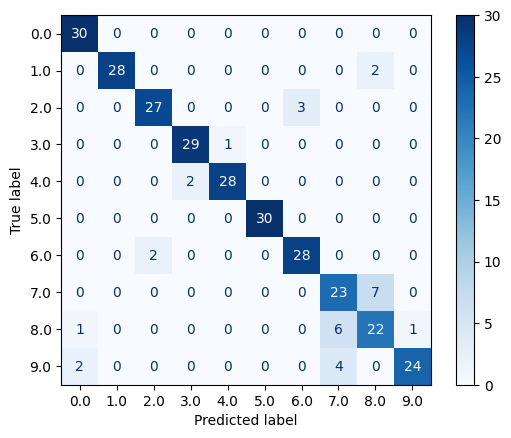

In [3]:
# Dividir o conjunto de dados em treino e teste (mantendo a mesma proporção de classes em ambos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Calcular os descritores estatísticos dos sinais de vibração do conjunto de treino e teste
descrX_train = calculate_statistics(X_train)
descrX_test = calculate_statistics(X_test)

# Treinar o modelo KNN no domínio do Tempo
knn_model = KNeighborsClassifier(n_neighbors=3) # ← usamos três pontos próximos nesse modelo
knn_model.fit(descrX_train, y_train) # ← não entramos com o sinal, mas sim seus descritores

# Testar o modelo
y_pred = knn_model.predict(descrX_test)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)

# Métricas de Desempenho
precision, recall, accuracy, specificity, f1score, df = calculate_metrics(cm)
df


# # Para visualizar a classificação
# true_value=0
# false_value=0

# for y_i_pred, y_i_test in zip(y_pred, y_test):
#     value = y_i_pred == y_i_test
#     if value:
#         true_value+=1
#     else:
#         false_value+=1

# print('true :',true_value)
# print('false :',false_value)

## <span style="font-size: 28px;"> Domínio Wavelet </span>

,Classe,Precision,Recall,Accuracy,Specificity,F1 Score
0,1,0.971429,0.971429,0.993333,0.996226,0.971429
1,2,0.952381,1.000000,0.996667,0.996429,0.975610
2,3,0.971429,0.918919,0.986667,0.996198,0.944444
3,4,1.000000,0.970588,0.996667,1.000000,0.985075
4,5,0.958333,0.958333,0.993333,0.996377,0.958333
5,6,0.970588,1.000000,0.996667,0.996255,0.985075
6,7,0.906250,0.966667,0.986667,0.988889,0.935484
7,8,0.916667,0.956522,0.990000,0.992780,0.936170
8,9,0.962963,0.896552,0.986667,0.996310,0.928571
9,10,0.971429,0.971429,0.993333,0.996226,0.971429


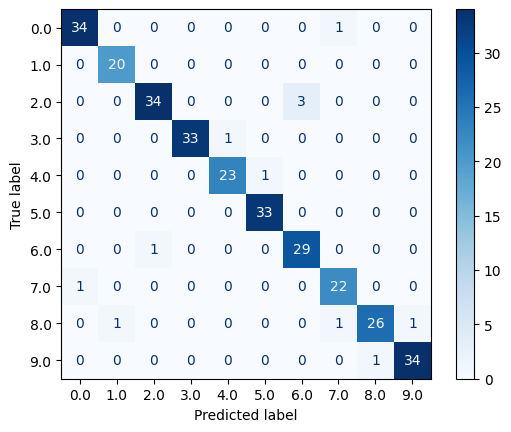

In [4]:
# Construir modelos usando os dados no domínio wavelet
wavelet = 'sym8'
level = 3

# Captura dimensões dos dados
n_samples, n_features = X.shape

# # O level máximo de escalonamento que essa configuração de wavelet permite para os dados em questão
max_level = pywt.dwt_max_level(n_features, wavelet)

# Se o level configurado for menor que o máximo possível, podemos prosseguir
if level <= max_level:
    
    # Decompor os sinais usando a wavelet escolhida e o nível de decomposição
    mat_coeficientes_wavelet = []
    for i in range(n_samples):
        coeffs = pywt.wavedec(X[i, :], wavelet, level=level)
        flattened_coeffs = np.concatenate(coeffs)
        mat_coeficientes_wavelet.append(flattened_coeffs)
    arr_coeficientes_wavelet = np.array(mat_coeficientes_wavelet)


    # Dividir os dados em treinamento e teste (70% treinamento, 30% teste)
    X_train, X_test, y_train, y_test = train_test_split(arr_coeficientes_wavelet, y, test_size=0.3, random_state=42)

    # Calcular os descritores estatísticos dos sinais de vibração do conjunto de treino e teste
    descrX_train = calculate_statistics(X_train)
    descrX_test = calculate_statistics(X_test)

    # Treinar o modelo KNN no domínio do Tempo
    knn_model = KNeighborsClassifier(n_neighbors=3) # ← usamos três pontos próximos nesse modelo
    knn_model.fit(descrX_train, y_train) # ← não entramos com o sinal, mas sim seus descritores

    # Testar o modelo
    y_pred = knn_model.predict(descrX_test)

    # Gerar a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap=plt.cm.Blues)

    # Métricas de Desempenho
    precision, recall, accuracy, specificity, f1score, df = calculate_metrics(cm)

else:
    raise ValueError(f'Não é possível dividir este conjunto de dados em um valor superior a {max_level}. Diminua o level')

df